# **Lab 2 - Detecting and Mitigating Biases using Fairlearn**

**Following Labs:**

*   Lab2: Detecting bias and mitigating bias via pre-processing interventions
*   Lab3: Mitigating bias via in-processing and postprocessing interventions

#Detecting Bias Using Fairlearn

## Bias in ML

A machine learning algorithm will attempt to find patterns, or generalizations, in the training dataset to use when a prediction for a new instance is needed. For example, the model may discover a pattern whereby a person with a salary over \$40,000 and an outstanding debt of less than $5 is very likely to repay a loan.

However, sometimes the patterns that are found and replicated by a model may not be desirable or, even worse, might be illegal. For example, a loan repayment model may determine that age plays a significant role in the prediction of repayment because the training dataset happened to have better repayment for one age group compared to another. This raises two problems: 1) the training dataset may not be representative of the true population of loan applications for all age groups, and 2) even if it is representative, it is illegal (with limited exceptions) to base loan decisions on an applicant's age, regardless of whether this is an accurate basis for prediction based on historical data.

The loan scenario describes an intuitive example of illegal bias. However, not all undesirable biases in machine learning are illegal; it may also exist in more subtle ways. For example, a loan company may want a diverse portfolio of customers across all income levels, and thus, will deem it undesirable if they are making more loans to high income levels over low income levels. Although this is not illegal or unethical, it is undesirable for the company's strategy.

## The `Fairlearn` toolkit

Fairlearn is a toolkit designed to help address this problem with fairness metrics and bias mitigators. Fairness metrics can be used to check for bias in machine learning workflows. Bias mitigators can be used to overcome bias in the workflow to produce a more fair outcome.

As these two examples illustrate, a bias detection and/or mitigation toolkit needs to be tailored to the particular bias of interest. More specifically, we need to define the attribute(s), called protected (or sensitive) attributes of interest: the attribute whose skewness/bias we are trying to detect and mitigate. The term suggests that the system designer should be sensitive to these features when assessing and mitigating group fairness.

Several stages of the machine learning pipeline are susceptible to bias. One useful way to categorize these stages are, intuitively, 'before,' 'during,' and 'after' training a model. These stages are commonly referred to as *pre-processing*, *in-processing*, and *post-processing* (in Fairlearn, in-processing techniques are available in the *reductions* package).

## Fairlearn

In Labs 2 and 3 we will use Fairlearn to detect and mitigate bias in a classifier. We will use the [ACS PUMS files](https://www.census.gov/programs-surveys/acs/microdata.html), particularly a fraction of the ACS Income dataset, and train a classifier to predict whether an individual has a salary greater than $50K. The protected attribute will be the sex of the individual.

In this Lab 2 notebook, we will:

1. Load the dataset and conduct basic data exploration and preprocessing
2. Explore possible fairness metrics
3. Train a logistic regression classifier and evaluate the fairness of this classifier
4. Train other logistic regression classifiers with pre-processing interventions and re-evaluate fairness
5. Compare the results obtained in 3 and 4

#1. Import Statements
First, we install Fairlearn and import the necessary packages

**BEWARE**: On Colab, you will probably have to restart the runtime (in the `Runtime` dropdown menu at the top of the screen) to import these successfully.

In [46]:
%%capture
#@markdown

!pip install fairlearn
!pip install folktables
!pip install matplotlib==3.4.1 --force-reinstall
!git clone https://github.com/lurosenb/superquail

In [47]:
#@markdown
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as skm
from sklearn.model_selection import cross_val_score
import matplotlib.ticker as ticker

from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage, ACSTravelTime
from superquail.data.acs_helper import ACSData

from fairlearn.metrics import MetricFrame
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, selection_rate
from fairlearn.metrics import false_negative_rate, false_positive_rate

from IPython.display import clear_output 

#2. Load Data, Conduct Exploratory Analysis, and Preprocess Data
Next, we will load the Folktables dataset.  The Folktables dataset is taken from US Census Data and is built to solve a few simple prediction tasks. The sample we pull is data from 2018 in California. The column names are described in the table below. Note that certain categorical variables have been mapped to integer values, which we will keep as-is for the following analyses.

For more information on the this dataset, please see the following paper (namely page 18): https://eaamo2021.eaamo.org/accepted/acceptednonarchival/EAMO21_paper_16.pdf

| Column Name | Feature | Description/Notes |
| --- | ----------- | --- |
| PINCP | Total person’s income | (Target) 1 if >= $50k, 0 if less |
| SEX | Sex | (Sensitive Attribute) Male=1, Female=2 |
| RAC1P | Race | (Sensitive Attribute) White=1, Black=2, Other races are between 3 and 9 |
| AGEP | Age | Ranges from 0-99 |
| COW | Class of Worker | Ranges 1-9, see paper for description |
| SCHL | Education Level | Ranges 1-24, see paper for description |
| MAR | Marital Status | Ranges 1-5, see paper for description |
| OCCP | Occupation | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| POBP | Place of Birth | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| RELP | Relationship | Relationship of individual to person who responded to the Census taker. Ranges 0-17, see paper for description |
| WKHP | Hours worked per week | Ranges from 0-99, averaged over previous year |

In [48]:
#@markdown Read in the folktables dataset 
full_df, features_df, target_df, groups_df = ACSData().return_acs_data_scenario(scenario="ACSIncome", subsample=70000)

print(full_df.shape)
full_df.head()

(70000, 11)


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PINCP
0,59.0,1.0,16.0,5.0,4540.0,247.0,12.0,40.0,1.0,6.0,1.0
1,32.0,1.0,19.0,1.0,1108.0,6.0,1.0,30.0,2.0,1.0,0.0
2,22.0,1.0,13.0,5.0,4350.0,6.0,7.0,40.0,1.0,9.0,0.0
3,31.0,1.0,21.0,1.0,4621.0,8.0,1.0,32.0,2.0,9.0,0.0
4,49.0,1.0,21.0,1.0,3255.0,233.0,0.0,36.0,2.0,6.0,1.0


In [49]:
#@markdown Check missing values and data types
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    70000 non-null  float64
 1   COW     70000 non-null  float64
 2   SCHL    70000 non-null  float64
 3   MAR     70000 non-null  float64
 4   OCCP    70000 non-null  float64
 5   POBP    70000 non-null  float64
 6   RELP    70000 non-null  float64
 7   WKHP    70000 non-null  float64
 8   SEX     70000 non-null  float64
 9   RAC1P   70000 non-null  float64
 10  PINCP   70000 non-null  float64
dtypes: float64(11)
memory usage: 5.9 MB


In [50]:
#@markdown Change data types of categorical features
numerical_cols = ['AGEP','WKHP']
categorical_cols = ['COW','SCHL','MAR','OCCP','POBP','RELP','RAC1P','SEX']

for col in categorical_cols:
  full_df[col] = full_df[col].astype('int')
  full_df[col] = full_df[col].astype('str')

full_df.info()
full_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    70000 non-null  float64
 1   COW     70000 non-null  object 
 2   SCHL    70000 non-null  object 
 3   MAR     70000 non-null  object 
 4   OCCP    70000 non-null  object 
 5   POBP    70000 non-null  object 
 6   RELP    70000 non-null  object 
 7   WKHP    70000 non-null  float64
 8   SEX     70000 non-null  object 
 9   RAC1P   70000 non-null  object 
 10  PINCP   70000 non-null  float64
dtypes: float64(3), object(8)
memory usage: 5.9+ MB


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PINCP
0,59.0,1,16,5,4540,247,12,40.0,1,6,1.0
1,32.0,1,19,1,1108,6,1,30.0,2,1,0.0
2,22.0,1,13,5,4350,6,7,40.0,1,9,0.0
3,31.0,1,21,1,4621,8,1,32.0,2,9,0.0
4,49.0,1,21,1,3255,233,0,36.0,2,6,1.0


Next, we will conduct some basic exploratory analysis of the data beginning with plotting the distributions of our features.

/var/folders/v1/6k_h9wg90q56lxft6dxycw200000gn/T/ipykernel_55002/3702193100.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1,2].set_yticklabels(labels)


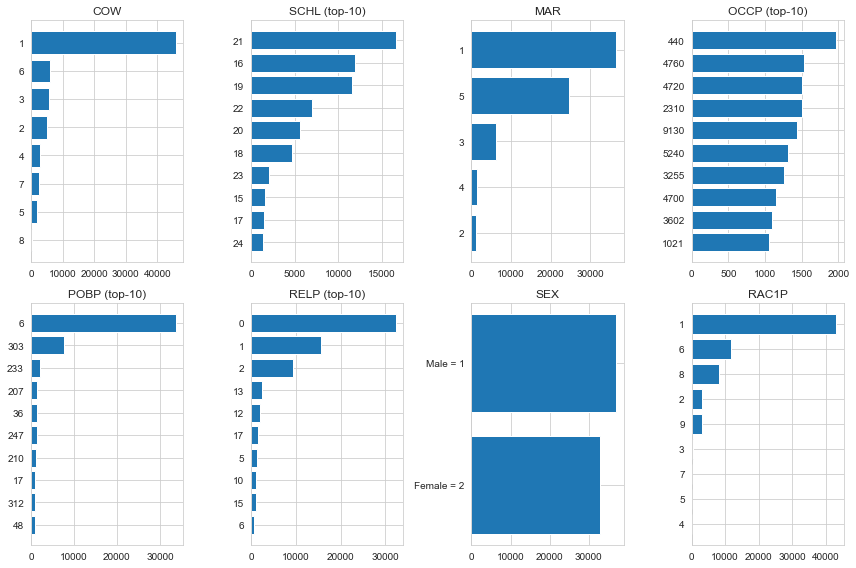

In [51]:
#@markdown Plot distribution of categorical columns
fig, ax = plt.subplots(2,4,figsize=(12,8))
ax[0,0].barh(full_df['COW'].value_counts().index[::-1], full_df['COW'].value_counts()[::-1])
ax[0,0].set_title('COW')

ax[0,1].barh(full_df['SCHL'].value_counts().index[:10][::-1], full_df['SCHL'].value_counts()[:10][::-1])
ax[0,1].set_title('SCHL (top-10)')

ax[0,2].barh(full_df['MAR'].value_counts().index[::-1], full_df['MAR'].value_counts()[::-1])
ax[0,2].set_title('MAR')

ax[0,3].barh(full_df['OCCP'].value_counts().index[:10][::-1], full_df['OCCP'].value_counts()[:10][::-1])
ax[0,3].set_title('OCCP (top-10)')

ax[1,0].barh(full_df['POBP'].value_counts().index[:10][::-1], full_df['POBP'].value_counts()[:10][::-1])
ax[1,0].set_title('POBP (top-10)')

ax[1,1].barh(full_df['RELP'].value_counts().index[:10][::-1], full_df['RELP'].value_counts()[:10][::-1])
ax[1,1].set_title('RELP (top-10)')

ax[1,2].barh(full_df['SEX'].value_counts().index[::-1], full_df['SEX'].value_counts()[::-1])
ax[1,2].set_title('SEX')
labels = ('Female = 2', 'Male = 1')
ax[1,2].set_yticklabels(labels)

ax[1,3].barh(full_df['RAC1P'].value_counts().index[::-1], full_df['RAC1P'].value_counts()[::-1])
ax[1,3].set_title('RAC1P')

fig.tight_layout()

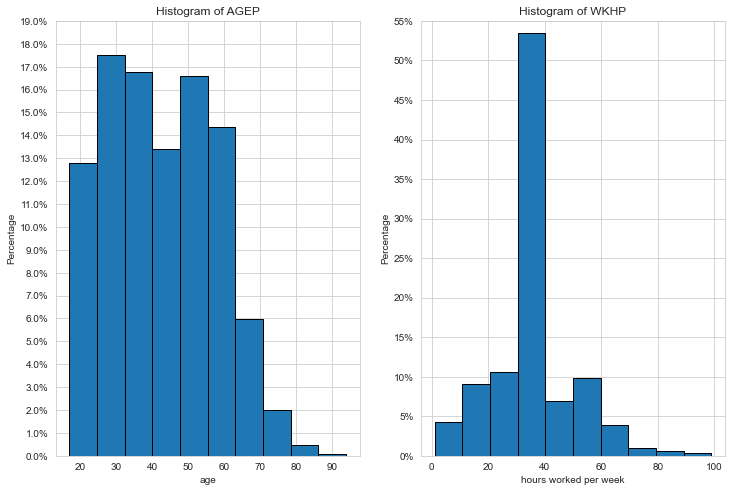

In [52]:
#@markdown Plot distribution of numeric features
fig, ax = plt.subplots(1,2,figsize=(12,8))

#histogram for AGEP (age)
num_of_bins_agep = 10
y_vals_agep, x_vals_agep, e_agep = ax[0].hist(full_df['AGEP'], bins=num_of_bins_agep, edgecolor='black')
ax[0].set_title("Histogram of AGEP")
ax[0].set_xlabel("age")
ax[0].set_ylabel("Percentage")
y_max_agep = round((max(y_vals_agep) / len(full_df)) + 0.02, 2)
ax[0].set_yticks(ticks=np.arange(0.0, y_max_agep * len(full_df), 0.01 * len(full_df)))
ax[0].set_ylim(ax[0].get_yticks()[0], ax[0].get_yticks()[-1])
ax[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(full_df)))

#histogram for WKHP (Hours worked per week)
num_of_bins_wkhp = 10
y_vals_wkhp, x_vals_wkhp, e_wkhp = ax[1].hist(full_df['WKHP'], bins=num_of_bins_wkhp, edgecolor='black')
ax[1].set_title("Histogram of WKHP")
ax[1].set_xlabel("hours worked per week")
ax[1].set_ylabel("Percentage")
y_max_wkhp = round((max(y_vals_wkhp) / len(full_df)) + 0.05, 2)
ax[1].set_yticks(ticks=np.arange(0.0, y_max_wkhp * len(full_df), 0.05 * len(full_df)))
ax[1].set_ylim(ax[1].get_yticks()[0], ax[1].get_yticks()[-1])
ax[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(full_df)))

As we can see, there is nothing very unusual about the distritubtion of the features in this dataset. Also, we note that the proportion of men and women is rather balanced.

We can also examine the pairwise correlations between the numeric features and our target variable.

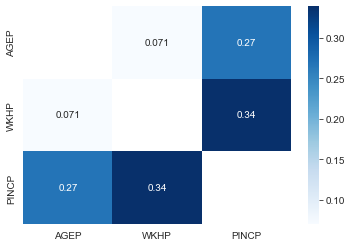

In [53]:
#@markdown Plot pairwise correlations between numeric features

sn.heatmap(full_df.corr(), mask=np.identity(len(full_df.corr())), annot=True, cmap='Blues')
plt.show()

Here, we can see that there are only relatively low correlations between our target variable (PINCP) and our numeric features of age and hours worked per week.

Next, we can look at the distribution of our target variable as well as the joint distribution of our protected and target attributes.

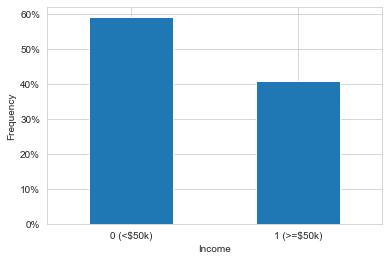

In [54]:
#@markdown Examine distribution of target variable
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
full_df['PINCP'].value_counts().divide(full_df.shape[0]).plot(kind='bar')
ax.set_xlabel('Income')
ax.set_ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=0, ha='center')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
labels_target = ('0 (<$50k)', '1 (>=$50k)')
ax.set_xticklabels(labels_target)
plt.show()

From the graph above we note that there is a considerable imbalance of the target variable. Let's see how is this distribution looks by gender.

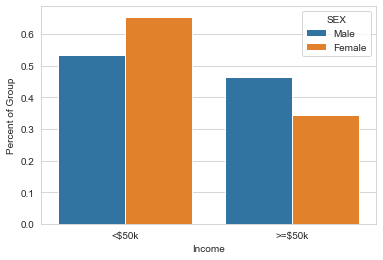

In [55]:
#@markdown Plot distribution of target variable among males and plot distribution of target variable among females
hist_df = full_df.groupby(['SEX','PINCP']).size().to_frame('count').reset_index()
new_col = full_df.groupby(['SEX']).PINCP.value_counts(normalize=True).values
hist_df['frac'] = new_col
hist_df.replace({'SEX': {'1': 'Male', '2': 'Female'}}, inplace=True)
hist_df.replace({'PINCP': {0.0: '<$50k', 1.0: '>=$50k'}}, inplace=True)
sn.barplot(x='PINCP', y='frac', hue='SEX', data=hist_df)
plt.ylabel('Percent of Group')
plt.xlabel('Income')
plt.show()

In [56]:
#@markdown Showing the number of Males and Females per Income group
full_df.groupby(['SEX', 'PINCP'])['PINCP'].count()

SEX  PINCP
1    0.0      19801
     1.0      17276
2    0.0      21567
     1.0      11356
Name: PINCP, dtype: int64

Here, we can see that the proportion of males who make at least \$50k is higher than the proportion of females who make at least $50k in this dataset. Thus, the initial finding about imbalance of the target variable is more accentuated for females.

# **TODO**: Given the graphs above, what results might we expect from our classifier when it comes to labelling males and females as high or low income?

**Answer**: That females are more likely to be marked as low income group and males are more likely to be marked as high income group, given the info from the histograms.

# **TODO**: Why might this data be biased? What type of bias is this?


**Answer**: The input data is already bias between genders. It is more ore less like a systematic bias that men is more often gain more advantage than women in workplace.

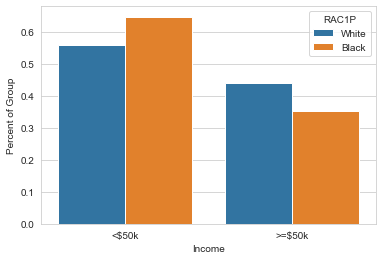

In [57]:
# @markdown #**TODO**: write some code in this cell that replicates the above histogram plot for black and white individuals in the data.
# TODO: write code here

hist_df = full_df.groupby(['RAC1P','PINCP']).size().to_frame('count').reset_index()
new_col = full_df.groupby(['RAC1P']).PINCP.value_counts(normalize=True).values
hist_df['frac'] = new_col
hist_df = hist_df[(hist_df['RAC1P'] == '1') | (hist_df['RAC1P'] == '2')]
#display(hist_df)
hist_df.replace({'RAC1P': {'1': 'White', '2': 'Black'}}, inplace=True)
hist_df.replace({'PINCP': {0.0: '<$50k', 1.0: '>=$50k'}}, inplace=True)
sn.barplot(x='PINCP', y='frac', hue='RAC1P', data=hist_df)
plt.ylabel('Percent of Group')
plt.xlabel('Income')
plt.show()

## Preprocessing
Next, we will do some preprocessing on our data to prepare it for use in our model.

In [58]:
#@markdown Standardize numerical features
scaler = StandardScaler()
full_df[numerical_cols] = scaler.fit_transform(full_df[numerical_cols])
display(full_df)

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PINCP
0,1.098333,1,16,5,4540,247,12,0.166982,1,6,1.0
1,-0.719153,1,19,1,1108,6,1,-0.601773,2,1,0.0
2,-1.392296,1,13,5,4350,6,7,0.166982,1,9,0.0
3,-0.786468,1,21,1,4621,8,1,-0.448022,2,9,0.0
4,0.425190,1,21,1,3255,233,0,-0.140520,2,6,1.0
...,...,...,...,...,...,...,...,...,...,...,...
69995,1.232961,1,9,1,8225,303,0,0.166982,1,8,1.0
69996,0.896390,6,21,5,410,6,0,0.935738,2,2,1.0
69997,-0.315267,1,18,5,4700,6,13,-0.448022,1,1,0.0
69998,-0.584525,1,19,1,5000,6,0,0.935738,1,1,1.0


In [59]:
#@markdown One-hot encode categorical features
full_df = pd.get_dummies(full_df, columns=categorical_cols)
display(full_df)

,AGEP,WKHP,PINCP,COW_1,COW_2,COW_3,COW_4,COW_5,COW_6,COW_7,...,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,SEX_1,SEX_2
0,1.098333,0.166982,1.0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,-0.719153,-0.601773,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-1.392296,0.166982,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,-0.786468,-0.448022,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,0.425190,-0.140520,1.0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,1.232961,0.166982,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
69996,0.896390,0.935738,1.0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
69997,-0.315267,-0.448022,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
69998,-0.584525,0.935738,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [60]:
#@markdown Since the sex attribute is already binary we can drop one of the redundant dummy columns
#note: males are now labeled as 1 and females are labeled as 0
full_df.drop(columns=['SEX_2'], inplace=True)
full_df.rename(columns={'SEX_1':'SEX'}, inplace=True)

full_df.head()

,AGEP,WKHP,PINCP,COW_1,COW_2,COW_3,COW_4,COW_5,COW_6,COW_7,...,RAC1P_1,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,SEX
0,1.098333,0.166982,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,-0.719153,-0.601773,0.0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,-1.392296,0.166982,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,-0.786468,-0.448022,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.425190,-0.140520,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


#3. Train Logistic Regression Classifier
Next, we will split our data into training and test sets randomly.  Then, we will train a logistic regression classifier and evaluate possible biases within that classifier.

### Aside: Accuracy as a Metric

Traditional machine learning (i.e. without a focus on fairness) often measures the quality of a classifier by it's **accuracy**, or what fraction of samples were labeled correctly:
$$
\text{Accuracy} = \frac{\text{Number of Correctly Labeled People}}{\text{Total Number of People}}
$$
This can also be expressed using the terms of the ["Confusion Matrix"](https://en.wikipedia.org/wiki/Confusion_matrix), where we let
- $\text{TP} = $ "True Positives" $ = \text{Num. people Correctly labeled as Positive}$
- $\text{FP} = $ "False Positives" $ = \text{Num. people Wrongly labeled as Positive}$
- $\text{TN} = $ "True Negatives" $ = \text{Num. people Correctly labeled as Negative}$
- $\text{FN} = $ "False Negatives" $ = \text{Num. people Wrongly labeled as Negative}$

Which lets us express the Accuacy as
$$
\text{Accuracy} = \frac{TP + TN}{TP + FP + TN + FN}
$$

In [70]:
#@markdown Split data into training and test sets
target = full_df['PINCP']
full_df.drop(columns='PINCP', inplace=True)

#note: here we are setting a value for the random_state (seed) parameter so that the results of this lab will remain consistent
X_train, X_test, y_train, y_test = train_test_split(full_df, target, test_size=0.2, random_state=4)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')



X_train shape: (56000, 810)
X_test shape: (14000, 810)
y_train shape: (56000,)
y_test shape: (14000,)


In [71]:
#@markdown #**TODO**: What would be the accuracy ($\frac{(TP + TN)}{(TP + FP + TN + FN)}$) of a classifier that always predicts the majority label (baseline classifier)?
#@markdown Since the majority label is 0, the accuracy of this majority label classifier would be the number of 0's over the total number of records.

# TODO: write code here

baseline_accuracy = 8239 / (8239 + 5761)
print(f'General baseline accuracy: {baseline_accuracy:.4f}')

y_test.value_counts()

General baseline accuracy: 0.5885


0.0    8244
1.0    5756
Name: PINCP, dtype: int64

In [72]:
# @markdown #**TODO**: What would be the accuracy ($\frac{(TP + TN)}{(TP + FP + TN + FN)}$) for the Male and Female groups considering a classifier that always predicts the majority label (baseline classifier) for each of these groups?

# TODO: write code here
display(y_test[X_test['SEX'] == 1].value_counts())
display(y_test[X_test['SEX'] == 0].value_counts())

male_baseline_accuracy = 3894 / (3894 + 3429)
female_baseline_accuracy = 4350 / (4350 + 2327)
print(f'Male baseline accuracy: {male_baseline_accuracy:.4f}')
print(f'Female baseline accuracy: {female_baseline_accuracy:.4f}')

0.0    3894
1.0    3429
Name: PINCP, dtype: int64

0.0    4350
1.0    2327
Name: PINCP, dtype: int64

Male baseline accuracy: 0.5317
Female baseline accuracy: 0.6515


In [73]:
#@markdown Implement logistic regression
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf_accuracy = clf.score(X_test, y_test)

clear_output()

print(f'Logistic Regression test accuracy: {clf_accuracy:.4f}')

Logistic Regression test accuracy: 0.8201


## Evaluate fairness

Next, we will evaluate the fairness of our classifier on the test set. We first define the **selection rate** of the classifier on a group:
$$
\text{Selection Rate} = \frac{\text{Number of People Classified Positive}}{\text{Total Number of People}}
$$
We will compute the selection rate amongst men and amongst women, and compare them. The difference of their selection rates is called the **Demographic parity difference**, and the ratio of their rates is called the **Demographic parity ratio**.

In general, if we have more than 2 classes,
- The demographic parity difference is the difference of the largest and smallest selection rates, so it is always positive. A demographic parity difference of 0 means that all groups have the same selection rate.

- The demographic parity ratio is the ratio of the smallest to largest selection rates, so it is always between 0 and 1, where a ratio of 1 means that all groups have the same selection rate.

<!-- Next, we will evaluate the fairness of our classifier on the test set.  We will first focus on two metrics - demographic parity difference and demographic parity ratio.  **Demographic parity difference** is defined as the difference between the largest and the smallest group-level selection rate across all values of the sensitive feature(s).  A demographic parity difference of 0 means that all groups have the same selection rate.  **Demographic parity ratio** is defined as the ratio between the smallest and the largest group-level selection rate across all values of the sensitive feature(s).  A demographic parity ratio of 1 means that all groups have the same selection rate. -->

More formally: let $X$ denote a feature vector used for predictions, $A$ be a single sensitive feature (such as age or race), $Y$ be the true label, and $h$ a classifier or predictor resulted from a Machine Learning algorithm. Then:

*Demographic Parity Difference* is defined as $(max_a\mathbb{E}[h(X)~|~  A = a])~ - ~ (min_a\mathbb{E}[h(X)~|~  A = a]) $


*Demographic Parity Ratio* is defined as $\frac{max_a\mathbb{E}[h(X)~|~  A = a]}{min_a\mathbb{E}[h(X)~|~  A = a]} $

In [74]:
#@markdown Evaluate the fairness of the classifier using `demographic_parity_difference` and `demographic_parity_ratio`
#note: we are conducting this analysis over the test set

#compute test predictions
y_pred = clf.predict(X_test)

#compute demographic parity difference and demographic parity ratio
demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['SEX'])
demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['SEX'])

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

#compute selection rate for males and females
male_selection_rate = selection_rate(y_test[X_test['SEX']==1], y_pred[X_test['SEX']==1])
female_selection_rate = selection_rate(y_test[X_test['SEX']==0], y_pred[X_test['SEX']==0])

print(f'Male selection rate: {male_selection_rate:.4f}')
print(f'Female selection rate: {female_selection_rate:.4f}')

Demographic parity difference: 0.1369
Demographic parity ratio: 0.7053
Male selection rate: 0.4644
Female selection rate: 0.3275


Here, we can see that there are substantial differences in selection rates between males and females with males being significantly more likely to be classified as high income.

Fairlearn also provides the fairlearn.metrics.MetricFrame class to evaluate disparities in treatment between different sub-populations.

The **fairlearn.metrics.MetricFrame** object requires a minimum of four arguments:

*   The underlying metric function(s) to be evaluated
*   The true values
*   The predicted values
*   The sensitive feature values

Metric functions must have a signature ''fn(y_true, y_pred)'', i.e., require only two arguments.  Here we will again look at selection rate, but we will also examine a few other metrics.  We will use accuracy, selection rate, false negative rate, and false positive rate.

In [75]:
#@markdown Evaluate the fairness of the classifier using the MetricFrame class for the `SEX` variable

#changing sensitive feature inputs to be 'male' and 'female' instead of 1 and 0
sensitive_feature_sex = X_test['SEX'].replace({0:'female', 1:'male'})

#evaluation metrics
metrics = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_sex = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_sex)

The **fairlearn.metrics.MetricFrame** has the **overall** property, which evaluates the metrics on the entire dataset.

In [76]:
#@title
grouped_on_sex.overall

accuracy          0.820143
selection_rate    0.399143
FNR               0.233322
FPR               0.142528
dtype: float64

In [79]:
#@markdown # **TODO**: Evaluate fairness for the `RAC1P` variable (for black and white individuals at minimum), and show `grouped_on_race.overall` 

# TODO: write code here
#changing sensitive feature inputs to be 'male' and 'female' instead of 1 and 0
sensitive_feature_race = (X_test['RAC1P_1'] + 2 * X_test['RAC1P_2']).replace({0 : "Neither", 1 : "Black", 2 : "White"})
# X_test['bw'] = 0 if X_test['RELP_0']
# sensitive_feature_race = X_test['RAC1P'].replace({0:'female', 1:'male'})

#evaluation metrics
metrics = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_race = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_race)

In [80]:
#@markdown
grouped_on_race.overall

accuracy          0.820143
selection_rate    0.399143
FNR               0.233322
FPR               0.142528
dtype: float64

The **fairlearn.metrics.MetricFrame** object also has the **by_group** functionality. This displays the selected metrics evaluated on each subgroup defined by the categories in the sensitive_features (sex in our case).

In [81]:
#@title
grouped_on_sex.by_group

,accuracy,selection_rate,FNR,FPR
SEX,,,,
female,0.822675,0.327542,0.284486,0.120000
male,0.817834,0.464427,0.198600,0.167694


In [82]:
#@markdown # **TODO**: Display for `RAC1P` as well

# TODO: write code here
grouped_on_race.by_group

,accuracy,selection_rate,FNR,FPR
sensitive_feature_0,,,,
Black,0.821789,0.438334,0.207769,0.154506
Neither,0.820304,0.337711,0.280417,0.123087
White,0.794521,0.325342,0.319588,0.148718


Reminder: Females are labeled 0 and males are labeled 1.

In [ ]:
#@markdown Plot the metric values

metrics_1 = {'accuracy': skm.accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           }

metrics_2 = {
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_sex_accuracy_selection = MetricFrame(metrics=metrics_1,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_sex)

grouped_on_sex_fpr_fnr = MetricFrame(metrics=metrics_2,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_sex)

grouped_on_sex_accuracy_selection.by_group.plot.bar(
    subplots=False, 
    figsize=(10, 7), 
    ylim=[0,1],
    title="Accuracy and selection rate by sex",
    )

grouped_on_sex_fpr_fnr.by_group.plot.bar(
    subplots=False, 
    figsize=(10, 7), 
    ylim=[0,1],
    title="FNR and FPR by sex",
    )

<AxesSubplot:title={'center':'FNR and FPR by sex'}, xlabel='sensitive_feature_0'>

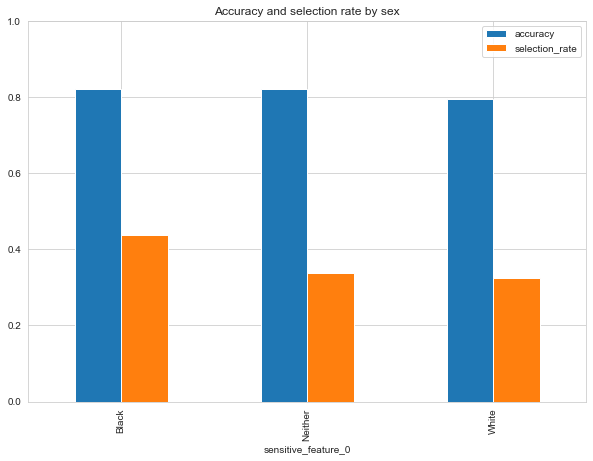

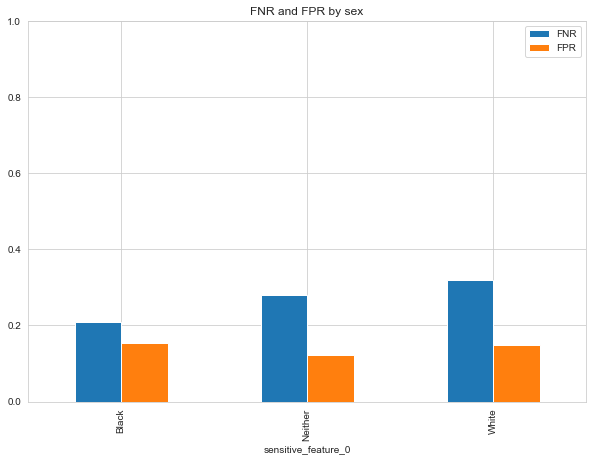

In [83]:
# @markdown #**TODO**: Replicate the above plots for at `RAC1P` and at least black/white individuals in the data. 

# TODO: write code here


metrics_1 = {'accuracy': skm.accuracy_score,
             'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
             }

metrics_2 = {
    'FNR': false_negative_rate,
    'FPR': false_positive_rate
}

grouped_on_race_accuracy_selection = MetricFrame(metrics=metrics_1,
                                                y_true=y_test,
                                                y_pred=y_pred,
                                                sensitive_features=sensitive_feature_race)

grouped_on_race_fpr_fnr = MetricFrame(metrics=metrics_2,
                                     y_true=y_test,
                                     y_pred=y_pred,
                                     sensitive_features=sensitive_feature_race)

grouped_on_race_accuracy_selection.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="Accuracy and selection rate by sex",
)

grouped_on_race_fpr_fnr.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="FNR and FPR by sex",
)

# **TODO**: Observe that accuracy for male and female groups is comparable, and yet we see disparities in FPR and FNR.  Which group benefits from the discrepancies in FPR and FNR shown above?  If you were deploying this system how would you measure performance (eg. accuracy, FNR, FPR)? (Reminder: females are labelled 0, males are labelled 1)


**Answer**:
White people group benefits from the discrepancies in FPR and FNR shown above (than black). And male benefits from the lower FPR rates (than females). I would consider the ratio of FNR and FPR to be a more balanced consideration, and i would not consider accuracy.


#4. Train "Blind" Logistic Regression Classifier (Fairness through Blindness)

Next, we will remove the protected attribute of "sex" from our data and see what effect this has on the performance of our classifier.

In [84]:
# @markdown Remove sensitive attribute from data
X_train_blind = X_train.drop(columns='SEX')
X_test_blind = X_test.drop(columns='SEX')

In [85]:
# @markdown Implement logistic regression
clf_blind = LogisticRegression()
clf_blind.fit(X_train_blind, y_train) 
clf_blind_accuracy = clf_blind.score(X_test_blind, y_test)

clear_output()

print(f'Logistic Regression test accuracy (without sensitive attribute): {clf_blind_accuracy:.4f}')

Logistic Regression test accuracy (without sensitive attribute): 0.8166


In [86]:
# @markdown Recall the accuracy fairness of the original classifier
print('Recall the original classifier:')
print(f'Logistic Regression test accuracy: {clf_accuracy:.4f}')
print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')
print(f'Male selection rate: {male_selection_rate:.4f}')
print(f'Female selection rate: {female_selection_rate:.4f}')

Recall the original classifier:
Logistic Regression test accuracy: 0.8201
Demographic parity difference: 0.1369
Demographic parity ratio: 0.7053
Male selection rate: 0.4644
Female selection rate: 0.3275


In [87]:
# @markdown Evaluate fairness of the blind classifier

#compute test predictions
y_pred_blind = clf_blind.predict(X_test_blind)

#compute demographic parity difference and demographic parity ratio
demo_parity_diff_blind = demographic_parity_difference(y_test, y_pred_blind, sensitive_features=X_test['SEX'])
demo_parity_ratio_blind = demographic_parity_ratio(y_test, y_pred_blind, sensitive_features=X_test['SEX'])

print(f'Demographic parity difference (without sensitive attribute): {demo_parity_diff_blind:.4f}')
print(f'Demographic parity ratio (without sensitive attribute): {demo_parity_ratio_blind:.4f}')

#compute selection rate for males and females
male_selection_rate_blind = selection_rate(y_test[X_test['SEX']==1], y_pred_blind[X_test['SEX']==1])
female_selection_rate_blind = selection_rate(y_test[X_test['SEX']==0], y_pred_blind[X_test['SEX']==0])

print(f'Male selection rate (without sensitive attribute): {male_selection_rate_blind:.4f}')
print(f'Female selection rate (without sensitive attribute): {female_selection_rate_blind:.4f}')



Demographic parity difference (without sensitive attribute): 0.0822
Demographic parity ratio (without sensitive attribute): 0.8129
Male selection rate (without sensitive attribute): 0.4396
Female selection rate (without sensitive attribute): 0.3573


# **TODO:** describe the differences of both models in terms of accuracy and fairness among male and female groups?


**Answer**:
The disparity in demographic parity has seen a substantial reduction, however, the variation in male and female selection rate remains unchanged.

**Nevertheless**, we see that removing the protected feature did not eliminate the biases within our classifier, as exhibited below.

In [ ]:
# @markdown Evaluate the biases of the classifier using the MetricFrame class
grouped_on_sex_blind = MetricFrame(metrics=metrics,
                                     y_true=y_test,
                                     y_pred=y_pred_blind,
                                     sensitive_features=sensitive_feature_sex)

In [ ]:
# @markdown
grouped_on_sex_blind.overall

In [ ]:
# @markdown
grouped_on_sex_blind.by_group

## **Showing all the metrics for the full data and blinded data.**

In [ ]:
# @markdown Comparing the results: full-data vs. blinded data

#demographic parity difference
demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['SEX'])
demo_parity_diff_blind = demographic_parity_difference(y_test, y_pred_blind, sensitive_features=X_test['SEX'])

#demographic parity ratio
demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['SEX'])
demo_parity_ratio_blind = demographic_parity_ratio(y_test, y_pred_blind, sensitive_features=X_test['SEX'])

#selection rate
male_selection_rate = selection_rate(y_test[X_test['SEX']==1], y_pred[X_test['SEX']==1])
male_selection_rate_blind = selection_rate(y_test[X_test['SEX']==1], y_pred_blind[X_test['SEX']==1])

female_selection_rate = selection_rate(y_test[X_test['SEX']==0], y_pred[X_test['SEX']==0])
female_selection_rate_blind = selection_rate(y_test[X_test['SEX']==0], y_pred_blind[X_test['SEX']==0])

#fnr
male_fnr = false_negative_rate(y_test[X_test['SEX']==1], y_pred[X_test['SEX']==1])
male_fnr_blind = false_negative_rate(y_test[X_test['SEX']==1], y_pred_blind[X_test['SEX']==1])

female_fnr = false_negative_rate(y_test[X_test['SEX']==0], y_pred[X_test['SEX']==0])
female_fnr_blind = false_negative_rate(y_test[X_test['SEX']==0], y_pred_blind[X_test['SEX']==0])

#fpr
male_fpr = false_positive_rate(y_test[X_test['SEX']==1], y_pred[X_test['SEX']==1])
male_fpr_blind = false_positive_rate(y_test[X_test['SEX']==1], y_pred_blind[X_test['SEX']==1])

female_fpr = false_positive_rate(y_test[X_test['SEX']==0], y_pred[X_test['SEX']==0])
female_fpr_blind = false_positive_rate(y_test[X_test['SEX']==0], y_pred_blind[X_test['SEX']==0])

#plot
labels = ['Demo Parity Diff','Demo Parity Ratio','Sel Rate (Male)',
          'Sel Rate (Female)', 'FNR (Male)', 'FNR (Female)', 'FPR(Male)',
          'FPR(Female)']

Y_full = [demo_parity_diff, demo_parity_ratio, male_selection_rate, 
          female_selection_rate, male_fnr, female_fnr, male_fpr, female_fpr]

Y_blind = [demo_parity_diff_blind, demo_parity_ratio_blind, 
           male_selection_rate_blind, female_selection_rate_blind, male_fnr_blind, 
           female_fnr_blind, male_fpr_blind, female_fpr_blind]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(15, 7))
rects1 = ax.bar(x - width/2, Y_full, width, label='Full Model')
rects2 = ax.bar(x + width/2, Y_blind, width, label='Blind Model')

ax.set_title('Metrics Comparison', size=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize='x-large')
ax.bar_label(rects1, padding=3, fmt='%.3f')
ax.bar_label(rects2, padding=3, fmt='%.3f')
ax.set_ylim([0, 1])
fig.tight_layout()
plt.rcParams["figure.figsize"] = (18,8)
plt.show()


# **TODO:** What are the key takeaways from this Lab?


**Answer**: That first of all, we need to be aware of the existing bias in large dataset and trending bias in the model training. Fairness through blindness could be helpful in adjusting bias but improvement is needed. 